This notebook describes the process we use to compare our synthetic microdata mimicking The Bureau of Labor Statistics' (BLS) QCEW dataset to the original BLS dataset.

The original data can be found here:
https://www.bls.gov/cew/downloadable-data-files.htm
by clicking on the quarterly, by area csv for the year 2016.

Upon downloading the file you may notice the difference in the directory structure of the BLS' data.

For example, for New Jersey (FIPS: 34), you will see that each county is split into its own csv,

```
'2016.q1-q4 34001 Atlantic County, New Jersey.csv'
'2016.q1-q4 34003 Bergen County, New Jersey.csv'
'2016.q1-q4 34005 Burlington County, New Jersey.csv'
...
```
whereas the generated synthetic data contains all counties in a single state file with `cnty` as a column.


First I want to make sure that all the counties are included in the generated microdata. This shouldn't be an issue but its safe to check.

Lets Check for New Jersey:

In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import numpy as np
import os

try:
    df = pd.read_csv("../OrigQCEWStudy/nj34_qdb_2016_1.csv")
    distinct_cnty = df['cnty'].unique()
    print("Distinct cnty values:")
    print(sorted(distinct_cnty))
except FileNotFoundError:
    print("Error: File not found.")

Distinct cnty values:
[np.int64(1), np.int64(3), np.int64(5), np.int64(7), np.int64(9), np.int64(11), np.int64(13), np.int64(15), np.int64(17), np.int64(19), np.int64(21), np.int64(23), np.int64(25), np.int64(27), np.int64(29), np.int64(31), np.int64(33), np.int64(35), np.int64(37), np.int64(39), np.int64(41)]


Comparing this list to the BLS' files for New Jersey shows that we have all the counties.

Now, to compare some basic summary statistics of both datasets, lets reformat the BLS data to only include the features that are generated in our microdata

## Step 1: Reformating the BLS' QCEW data
1. **First We will combine all of the county files into a single state file:**

        For now we are only looking at New Jersey


In [2]:
def load_combined_data(directory):

    dfs = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            
            # Read CSV file
            df = pd.read_csv(filepath)
            dfs.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)
    
    return combined_df

In [3]:
real_nj_data = load_combined_data('./TrueQCEW/NewJersey/')

Our generated microdata only looks at the first quarter.

Lets filter out any rows where `qtr` is not 1

In [4]:
real_nj_data = real_nj_data[real_nj_data['qtr'] == 1].copy()

In our generated microdata we have separate columns `state` and `cnty`

* `state` is simply the first two digits of the `area_fips` code in the QCEW dataset
* `cnty` is the next three digits

Lets create the `state` and `cnty` columns and remove any irrelevant columns

In [5]:
real_nj_data['state'] = real_nj_data['area_fips'].astype(str).str[:2]  # First 2 digits
real_nj_data['cnty'] = real_nj_data['area_fips'].astype(str).str[2:]   # Last 3 digits

# Remove the area_fips column
real_nj_data = real_nj_data.drop(columns=['area_fips'])
# List of columns to keep
columns_to_keep = [
    'year', 
    'qtr', 
    'state', 
    'cnty', 
    'own_code', 
    'industry_code', 
    'month1_emplvl', 
    'month2_emplvl', 
    'month3_emplvl',
    'total_qtrly_wages', 
    'avg_wkly_wage',
    'agglvl_code', 
    'disclosure_code'
]
real_nj_data = real_nj_data[columns_to_keep]

To make computations easier on the brain we will also rename some of these columns to match our synthetic data:

`month1_emplvl` -> `m1emp`

`month2_emplvl` -> `m2emp`

`month3_emplvl` -> `m3emp`

In [6]:
real_nj_data = real_nj_data.rename(columns={'month1_emplvl':'m1emp',
                                            'month2_emplvl':'m2emp',
                                            'month3_emplvl':'m3emp'
                                           })

Lets also load in the synthetic dataset for New Jersey

In [7]:
synth_nj_df = pd.read_csv('./nj34_qdb_2016_1.csv')


## Step 2. Looking at employment counts at various NAICS levels
You'll notice that in the actual QCEW dataset we are given industry codes of various digit lengths. These correspond with the North American Industry Classification System (NAICS).

In the synthetic dataset, we give `naics`, `naics3`, `naics4`, `naics5` and `naics_sector`.

the 6 digit `naics` code is the most specific industry classification for the establishment entry whereas naics_sector will be the most general industry classification.
### Looking at the 2 digit level
For now, lets look at both datasets, but only for a specific sector code. Lets say `22`. This means that we will only be interested in entries of the QCEW data where the first two digits of `industry_code` is `22` and entries of the synthetic dataset where `naics_sector=22`

Since our synthetic data only includes establishments with private ownership, we also filter out entries where `own_code` is not 5
https://www.bls.gov/cew/classifications/ownerships/ownership-titles.htm

In [8]:
synth_nj_df_22 = synth_nj_df[synth_nj_df['naics_sector'] == 22]
synth_nj_df_22.head()
# Group by county and sum the employment columns
# Group by the specified columns and sum the employment columns
synth_nj_df_22_sums = synth_nj_df_22.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics_sector']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()

synth_nj_df_22_sums

,year,qtr,state,cnty,own,naics_sector,m1emp,m2emp,m3emp
0,2016,1,34,1,5,22,755,753,750
1,2016,1,34,3,5,22,1089,1088,1085
2,2016,1,34,5,5,22,1884,1258,639
3,2016,1,34,7,5,22,320,324,323
4,2016,1,34,9,5,22,207,172,136
5,2016,1,34,11,5,22,236,171,97
6,2016,1,34,13,5,22,703,702,708
7,2016,1,34,15,5,22,272,272,274
8,2016,1,34,17,5,22,995,993,991
9,2016,1,34,19,5,22,192,148,99


In [9]:
real_nj_22 = real_nj_data[
    (real_nj_data['industry_code'].str[:2]=='22') &
    (real_nj_data['industry_code'].astype(str).str.len() == 2) &
    (real_nj_data['own_code'] == 5)
][['year', 'qtr', 'state', 'cnty', 'industry_code','own_code', 'm1emp', 'm2emp', 'm3emp']].copy()

real_nj_22

,year,qtr,state,cnty,industry_code,own_code,m1emp,m2emp,m3emp
1088,2016,1,34,011,22,5,0,0,0
6932,2016,1,34,029,22,5,1081,1079,1080
14088,2016,1,34,027,22,5,518,515,518
21256,2016,1,34,037,22,5,179,179,173
27396,2016,1,34,023,22,5,871,866,865
35068,2016,1,34,033,22,5,0,0,0
39320,2016,1,34,031,22,5,0,0,0
46440,2016,1,34,041,22,5,0,0,0
52276,2016,1,34,025,22,5,1435,1436,1425
60252,2016,1,34,013,22,5,614,614,616


Ok this is great! We can now see the employment values for naics sector 22 for each county. Lets throw this into a single dataframe and see these side by side. Instead of viewing two separate dataframes, Lets look at the differences in m1,m2,and m3emp for each county over the 2 digit naics.

In [10]:
# Convert cnty in real_nj_22 to integer to match synth_nj_df_22_sums format
real_nj_22['cnty'] = real_nj_22['cnty'].astype(int)
real_nj_22['state'] = real_nj_22['state'].astype(int)

# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_22_sums,
    real_nj_22,
    on=['year', 'qtr', 'state', 'cnty'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_22 = merged_df[['year', 'qtr', 'state', 'cnty', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]

# If you want to see counties with the largest absolute differences first
result_df_22 = result_df_22.sort_values(by='cnty', key=abs, ascending=True)
result_df_22

,year,qtr,state,cnty,m1emp_synth,m1emp_real,m1emp_diff,m2emp_synth,m2emp_real,m2emp_diff,m3emp_synth,m3emp_real,m3emp_diff
0,2016,1,34,1,755,711,44,753,709,44,750,730,20
1,2016,1,34,3,1089,1163,-74,1088,1163,-75,1085,1163,-78
2,2016,1,34,5,1884,574,1310,1258,567,691,639,566,73
3,2016,1,34,7,320,415,-95,324,405,-81,323,376,-53
4,2016,1,34,9,207,155,52,172,154,18,136,152,-16
5,2016,1,34,11,236,0,236,171,0,171,97,0,97
6,2016,1,34,13,703,614,89,702,614,88,708,616,92
7,2016,1,34,15,272,256,16,272,256,16,274,259,15
8,2016,1,34,17,995,0,995,993,0,993,991,0,991
9,2016,1,34,19,192,77,115,148,77,71,99,78,21


For rows where the real values are 0 or supressed (still 0 in the dataset) it's hard to tell what's going on...

Lets remove those rows and compute the mean and median difference in m1,m2,and m3emp.
#### Employment count results at specific 2-digit naics sector (22)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Summary stats for differences
diff_stats = result_df_22[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']].describe()
print("Difference Statistics:")
print(diff_stats)


Difference Statistics:
        m1emp_diff   m2emp_diff   m3emp_diff
count    21.000000    21.000000    21.000000
mean    576.666667   403.142857   227.857143
std    1001.245691   676.409734   520.148083
min    -143.000000  -143.000000  -126.000000
25%      16.000000    16.000000   -10.000000
50%      98.000000    71.000000    23.000000
75%     995.000000   691.000000   199.000000
max    3828.000000  2147.000000  2125.000000


These results look decent. We can see that for the specific naics sector (22), the median difference between the synthetic true employment counts are for the most part under 100. Though there isn't much data to tell us about the bigger picture. To fix this lack of data, lets scale this problem up and look at the median differences of employment values over all 2-digit naics.

### Looking over all 2-digit naics sectors

In [12]:
real_nj_data_2dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 2) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_2dig = synth_nj_df.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics_sector']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()

Some industry codes that appear in the synthetic dataset but not the real. This is because some of the two digit codes appear in the real dataset as ranges of codes. For example NAICS 31-33 is Manufacturing. 

We can also see that two codes appear in the real but not the synthetic.
These codes are:

`10: Total, all industries`

`99: Unclassified`

Instead of attempting to reformat the NAICS code ranges in the real dataset, lets simply remove these.

In [13]:
# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_2dig['naics_sector'] = synth_nj_df_2dig['naics_sector'].astype(str).str.strip().astype(int)
real_nj_data_2dig['industry_code'] = real_nj_data_2dig['industry_code'].astype(str).str.strip().astype(int)
# First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_2dig['naics_sector']).intersection(set(real_nj_data_2dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_2dig = synth_nj_df_2dig[synth_nj_df_2dig['naics_sector'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_2dig = real_nj_data_2dig[real_nj_data_2dig['industry_code'].isin(common_codes)]

/tmp/ipykernel_2842/3341525310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_2dig['industry_code'] = real_nj_data_2dig['industry_code'].astype(str).str.strip().astype(int)


Same as before we will take the differences in the emp values and remove any rows with zero as the real employment value.

In [14]:
real_nj_data_2dig['cnty'] = real_nj_data_2dig['cnty'].astype(int)
real_nj_data_2dig['state'] = real_nj_data_2dig['state'].astype(int)
real_nj_data_2dig['naics_sector'] = real_nj_data_2dig['industry_code']
# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_2dig,
    real_nj_data_2dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics_sector'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_2dig = merged_df[['year', 'qtr', 'state', 'cnty', 'naics_sector', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]
result_df_2dig = result_df_2dig[result_df_2dig['m1emp_real'] != 0]

### Results over all 2-digit naics

Now we will take some summary statistics of the differences in employment values

In [15]:
def empresultout(result_df, naicslevel):
    # Summary stats for differences
    diff_stats = result_df[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']].describe()
    print("Difference Statistics:")
    print(diff_stats)

    # Correlation matrix
    corr_matrix = result_df[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # By NAICS sector
    sector_stats = result_df.groupby(naicslevel)[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']].median()
    print("\nMedian Differences by NAICS Sector:")
    print(sector_stats)
    ##### Plots #####
    ## Box - no fliers
    # Calculate Relative differences
    result_df['m1emp_reldiff'] = (result_df['m1emp_synth'] - result_df['m1emp_real']) / result_df['m1emp_real']
    result_df['m2emp_reldiff'] = (result_df['m2emp_synth'] - result_df['m2emp_real']) / result_df['m2emp_real']
    result_df['m3emp_reldiff'] = (result_df['m3emp_synth'] - result_df['m3emp_real']) / result_df['m3emp_real']
    
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(15, 5))  # Adjusted figure size for single plot
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    sns.boxplot(data=result_df[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']],
           showfliers=False,
            ax=ax1
           )
    ax1.set_title(f'Distribution of Employment Differences (Synthetic - Real) ({naicslevel})')
    ax1.set_ylabel('Difference in Employment Counts')
    ax1.set_xlabel('Employment Metric')
    ax1.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    ax1.set_xticks([0, 1, 2], ['M1EMP', 'M2EMP', 'M3EMP'])
    
    sns.boxplot(data=result_df[['m1emp_reldiff', 'm2emp_reldiff', 'm3emp_reldiff']],
           showfliers=False,
           ax=ax2)
    ax2.set_title(f'Relative Employment Differences\n(Synthetic - Real) / (Real) ({naicslevel})')
    ax2.set_ylabel('Relative Difference')
    ax2.set_xlabel('Employment Metric')
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
    ax2.set_xticks([0, 1, 2], ['M1EMP', 'M2EMP', 'M3EMP'])
    
    plt.tight_layout()
    plt.show()
    ## Box with fliers
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(15, 5))  # Adjusted figure size for single plot
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    sns.boxplot(data=result_df[['m1emp_diff', 'm2emp_diff', 'm3emp_diff']],
           showfliers=True,
            ax=ax1
           )
    ax1.set_title(f'Distribution of Employment Differences (Synthetic - Real) ({naicslevel})')
    ax1.set_ylabel('Difference in Employment Counts')
    ax1.set_xlabel('Employment Metric')
    ax1.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    ax1.set_xticks([0, 1, 2], ['M1EMP', 'M2EMP', 'M3EMP'])
    
    sns.boxplot(data=result_df[['m1emp_reldiff', 'm2emp_reldiff', 'm3emp_reldiff']],
           showfliers=True,
           ax=ax2)
    ax2.set_title(f'Relative Employment Differences\n(Synthetic - Real) / (Real) ({naicslevel})')
    ax2.set_ylabel('Relative Difference')
    ax2.set_xlabel('Employment Metric')
    ax2.axhline(0, color='red', linestyle='--', alpha=0.7)
    ax2.set_xticks([0, 1, 2], ['M1EMP', 'M2EMP', 'M3EMP'])
    
    plt.tight_layout()
    plt.show()

    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(15, 5))

    metrics = ['m1emp', 'm2emp', 'm3emp']

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)

        # Scatter plot
        sns.scatterplot(
            data=result_df,
            x=f'{metric}_real',
            y=f'{metric}_synth',
            s=60,
            alpha=0.7
        )

        # Fit regression with statsmodels (for CI)
        X = sm.add_constant(result_df[f'{metric}_real'])  # Adds intercept
        model = sm.OLS(result_df[f'{metric}_synth'], X).fit()

        # Generate predictions with CI
        predictions = model.get_prediction(X)
        pred_frame = predictions.summary_frame(alpha=0.05)  # 95% CI

        # Plot regression line
        plt.plot(
            result_df[f'{metric}_real'],
            model.predict(X),
            color='blue',
            label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
        )

        # Plot CI
        plt.fill_between(
            result_df[f'{metric}_real'],
            pred_frame['obs_ci_lower'],
            pred_frame['obs_ci_upper'],
            color='blue',
            alpha=0.2,
            label='95% CI'
        )

        # Perfect agreement line
        max_val = max(result_df[f'{metric}_real'].max(), result_df[f'{metric}_synth'].max())
        plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect agreement')

        plt.title(f'Synthetic vs Real Employment ({metric.upper()}) ({naicslevel})')
        plt.xlabel('Real Employment')
        plt.ylabel('Synthetic Employment')
        plt.legend()

    plt.tight_layout()
    plt.show()

Difference Statistics:
         m1emp_diff   m2emp_diff   m3emp_diff
count    308.000000   308.000000   308.000000
mean     710.801948   565.561688   341.103896
std     1978.140020  1413.334007  1088.417584
min    -3858.000000 -3766.000000 -3664.000000
25%      -43.500000   -39.000000   -67.250000
50%      165.000000   196.000000   107.500000
75%      878.500000   762.250000   539.250000
max    16435.000000  8518.000000  6317.000000

Correlation Matrix:
            m1emp_diff  m2emp_diff  m3emp_diff
m1emp_diff    1.000000    0.953335    0.650284
m2emp_diff    0.953335    1.000000    0.842215
m3emp_diff    0.650284    0.842215    1.000000

Median Differences by NAICS Sector:
              m1emp_diff  m2emp_diff  m3emp_diff
naics_sector                                    
11                 -60.0       -78.5      -189.0
21                  21.5        25.5        -3.0
22                  51.0        45.0        17.5
23                 342.0       525.0       351.0
42                1202.

<Figure size 1500x500 with 0 Axes>

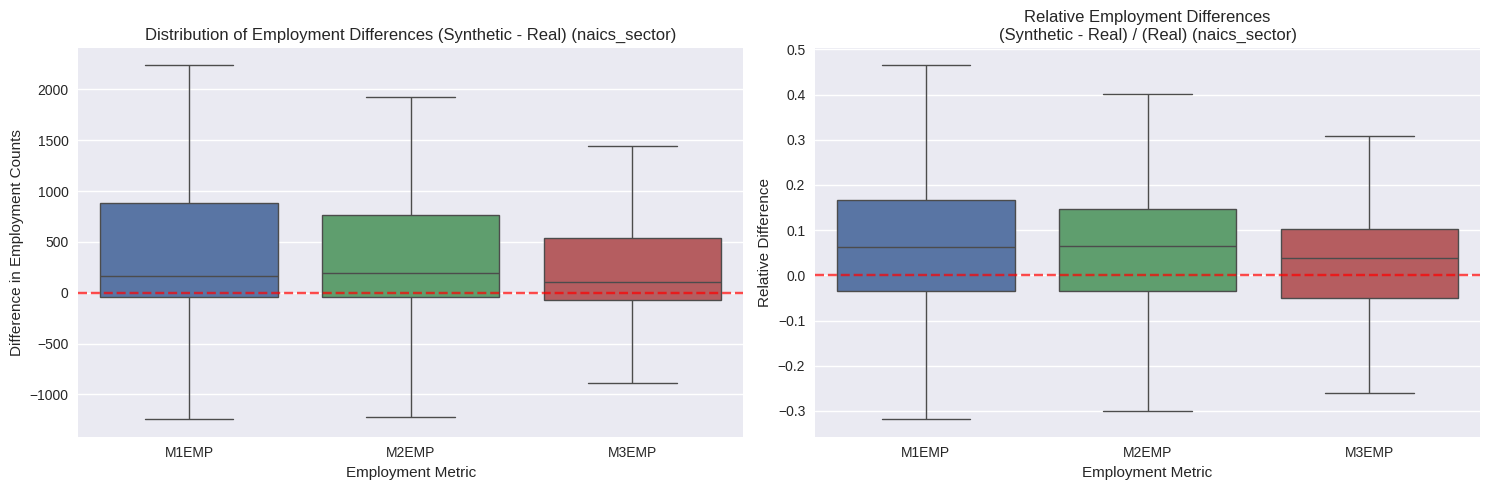

<Figure size 1500x500 with 0 Axes>

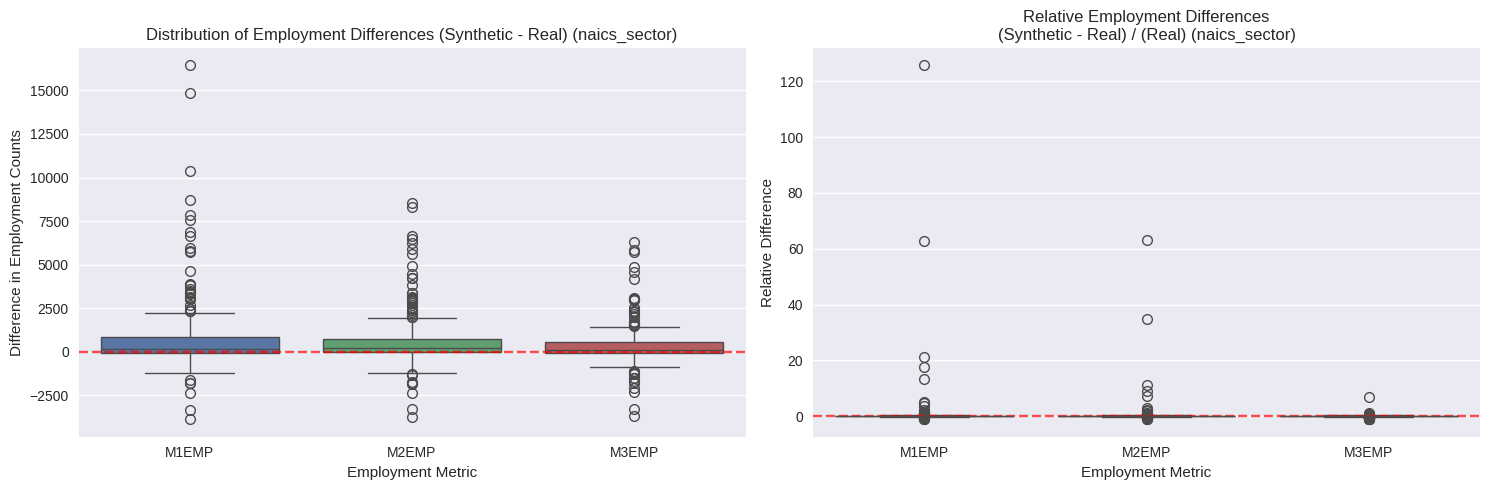

/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f

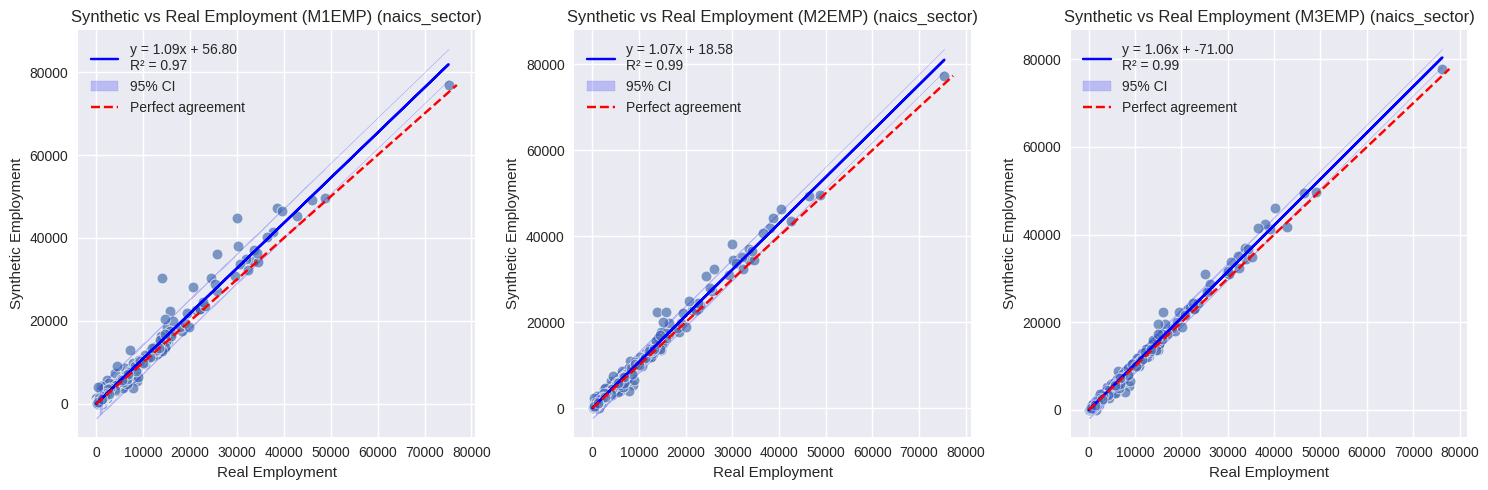

In [16]:
empresultout(result_df_2dig, 'naics_sector')

This looks great!

Now lets look at the higher-digit naics levels for some more specific insights:

### Looking at the 3-digit level

#### Setting up dfs

In [17]:
real_nj_data_3dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 3) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_3dig = synth_nj_df.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics3']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()
# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_3dig['naics3'] = synth_nj_df_3dig['naics3'].astype(str).str.strip().astype(int)
real_nj_data_3dig['industry_code'] = real_nj_data_3dig['industry_code'].astype(str).str.strip().astype(int)
# First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_3dig['naics3']).intersection(set(real_nj_data_3dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_3dig = synth_nj_df_3dig[synth_nj_df_3dig['naics3'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_3dig = real_nj_data_3dig[real_nj_data_3dig['industry_code'].isin(common_codes)]
real_nj_data_3dig['cnty'] = real_nj_data_3dig['cnty'].astype(int)
real_nj_data_3dig['state'] = real_nj_data_3dig['state'].astype(int)
real_nj_data_3dig['naics3'] = real_nj_data_3dig['industry_code']
# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_3dig,
    real_nj_data_3dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics3'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_3dig = merged_df[['year', 'qtr', 'state', 'cnty', 'naics3', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]
result_df_3dig = result_df_3dig[result_df_3dig['m1emp_real'] != 0]

/tmp/ipykernel_2842/1263198173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_3dig['industry_code'] = real_nj_data_3dig['industry_code'].astype(str).str.strip().astype(int)


### 3-digit level results

Difference Statistics:
         m1emp_diff   m2emp_diff   m3emp_diff
count   1086.000000  1086.000000  1086.000000
mean     372.613260   269.972376   142.829650
std     1105.792613   731.462695   527.500573
min    -1807.000000 -1819.000000 -1823.000000
25%       -5.000000    -4.000000   -18.000000
50%       54.000000    52.500000    17.500000
75%      312.750000   273.500000   148.250000
max    13785.000000  7163.000000  6259.000000

Correlation Matrix:
            m1emp_diff  m2emp_diff  m3emp_diff
m1emp_diff    1.000000    0.947981    0.538835
m2emp_diff    0.947981    1.000000    0.771684
m3emp_diff    0.538835    0.771684    1.000000

Median Differences by NAICS Sector:
        m1emp_diff  m2emp_diff  m3emp_diff
naics3                                    
114           35.0        20.5        -7.0
115            8.5        14.0        -6.0
212          -10.5        -6.5        -8.5
221           51.0        45.0        17.5
236           25.0        45.0        34.0
...            .

<Figure size 1500x500 with 0 Axes>

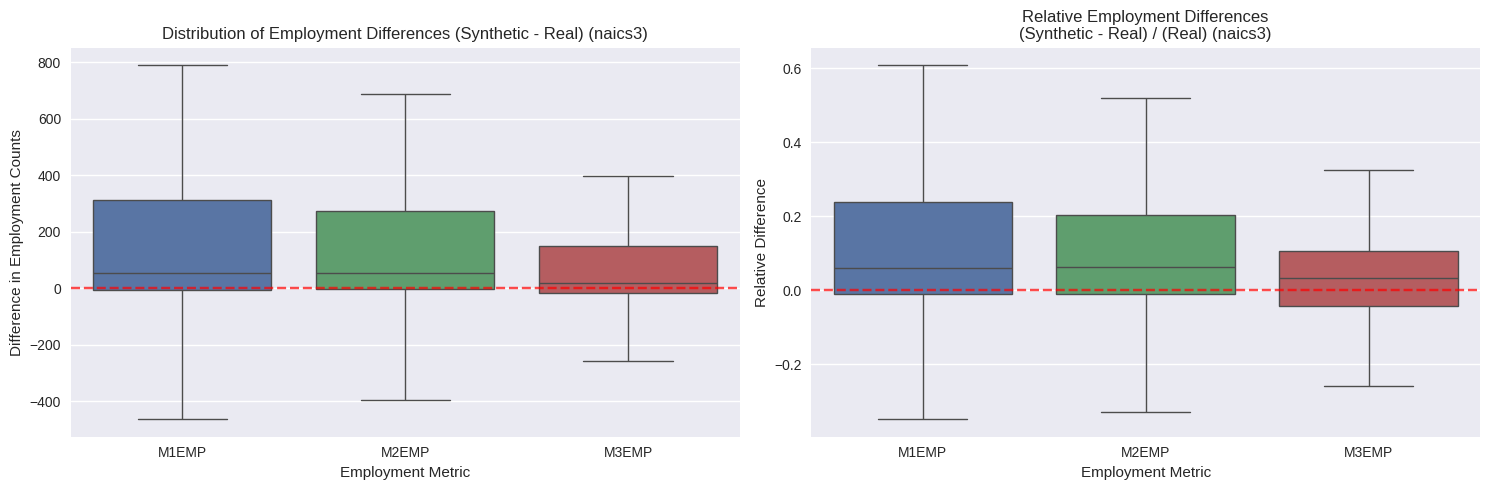

<Figure size 1500x500 with 0 Axes>

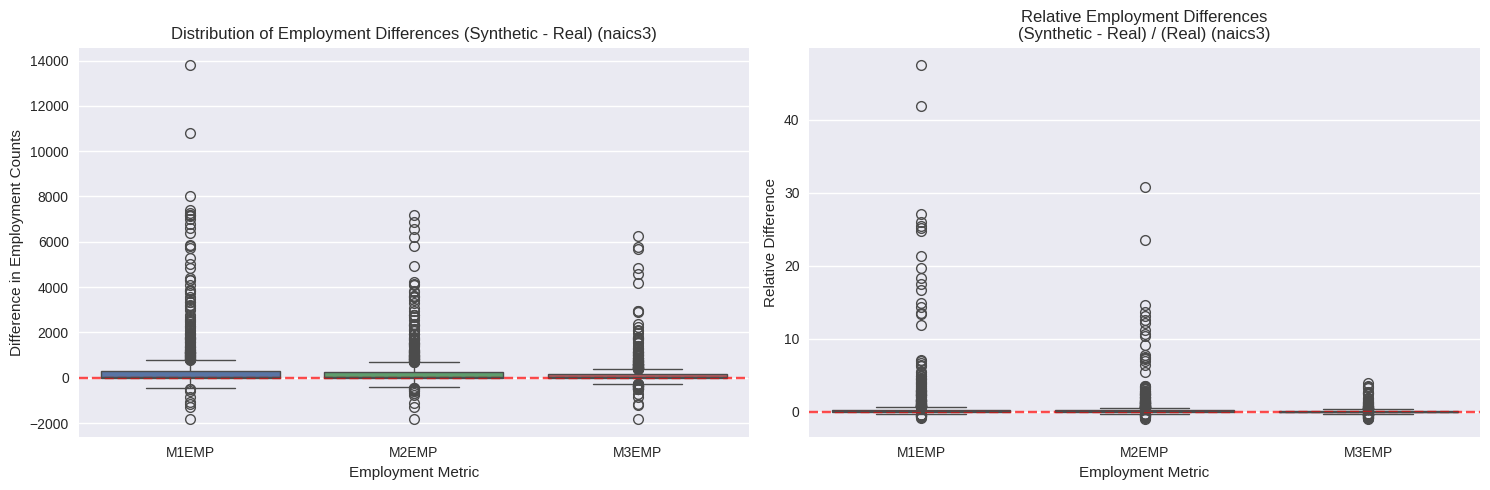

/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f

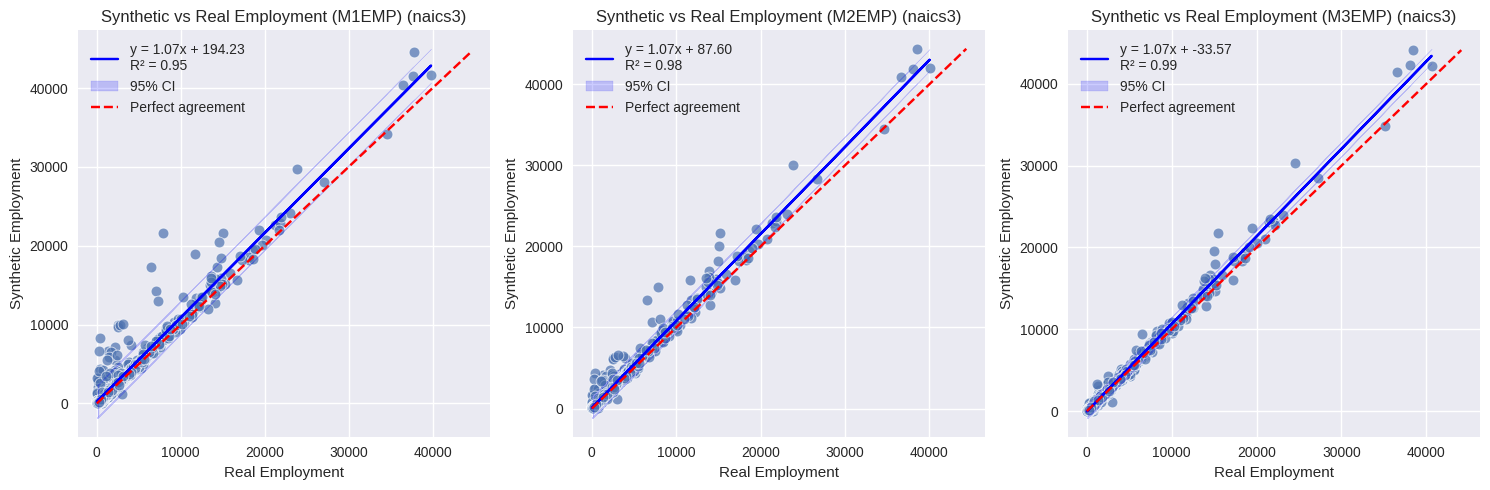

In [18]:
empresultout(result_df_3dig, 'naics3')

### Looking at the 4-digit level

#### Setting up dfs

In [19]:
real_nj_data_4dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 4) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_4dig = synth_nj_df.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics4']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()
# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_4dig['naics4'] = synth_nj_df_4dig['naics4'].astype(str).str.strip().astype(int)
real_nj_data_4dig['industry_code'] = real_nj_data_4dig['industry_code'].astype(str).str.strip().astype(int)
# First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_4dig['naics4']).intersection(set(real_nj_data_4dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_4dig = synth_nj_df_4dig[synth_nj_df_4dig['naics4'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_4dig = real_nj_data_4dig[real_nj_data_4dig['industry_code'].isin(common_codes)]
real_nj_data_4dig['cnty'] = real_nj_data_4dig['cnty'].astype(int)
real_nj_data_4dig['state'] = real_nj_data_4dig['state'].astype(int)
real_nj_data_4dig['naics4'] = real_nj_data_4dig['industry_code']
# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_4dig,
    real_nj_data_4dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics4'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_4dig = merged_df[['year', 'qtr', 'state', 'cnty', 'naics4', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]
result_df_4dig = result_df_4dig[result_df_4dig['m1emp_real'] != 0]

/tmp/ipykernel_2842/4140429712.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_4dig['industry_code'] = real_nj_data_4dig['industry_code'].astype(str).str.strip().astype(int)


### 4-digit level results

Difference Statistics:
        m1emp_diff   m2emp_diff   m3emp_diff
count  2786.000000  2786.000000  2786.000000
mean     54.229361    57.115937    51.221464
std     262.373830   252.534638   247.453295
min   -2045.000000 -2121.000000 -2503.000000
25%      -8.750000    -6.000000    -8.000000
50%       7.500000    10.000000     7.000000
75%      51.000000    55.750000    50.000000
max    5456.000000  5400.000000  5292.000000

Correlation Matrix:
            m1emp_diff  m2emp_diff  m3emp_diff
m1emp_diff    1.000000    0.983852    0.961609
m2emp_diff    0.983852    1.000000    0.984044
m3emp_diff    0.961609    0.984044    1.000000

Median Differences by NAICS Sector:
        m1emp_diff  m2emp_diff  m3emp_diff
naics4                                    
1141          -8.0        -5.0       -10.0
1151           7.0         7.0         5.0
1152          -3.5        -5.0        -4.5
2123         -10.5        -6.5        -8.5
2211           8.5        18.0        17.5
...            ...       

<Figure size 1500x500 with 0 Axes>

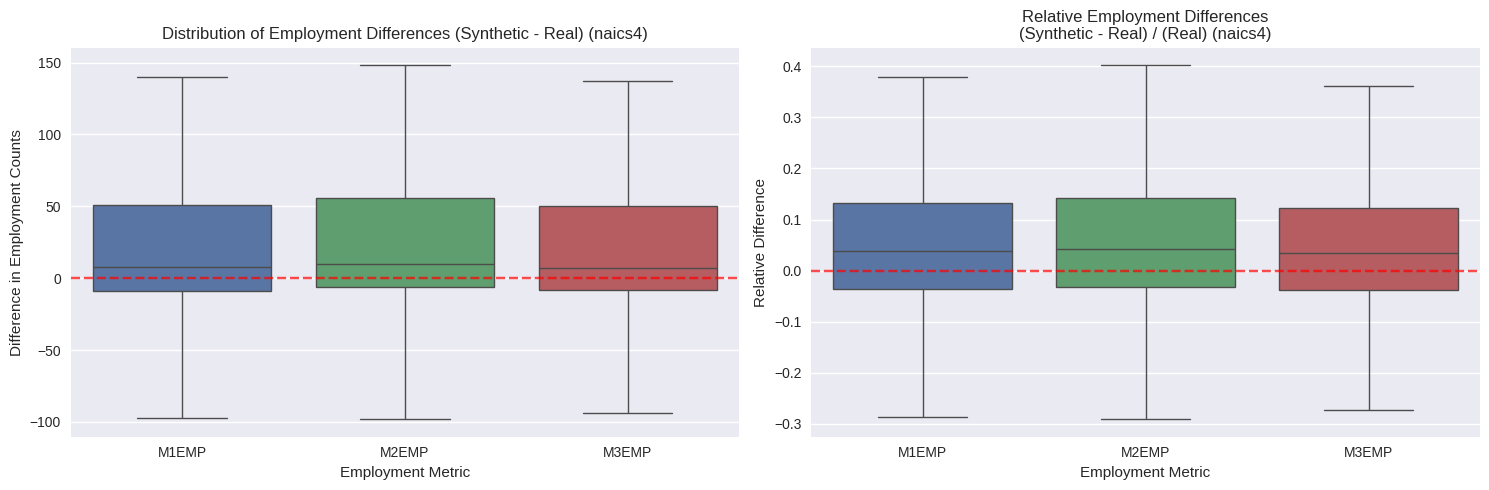

<Figure size 1500x500 with 0 Axes>

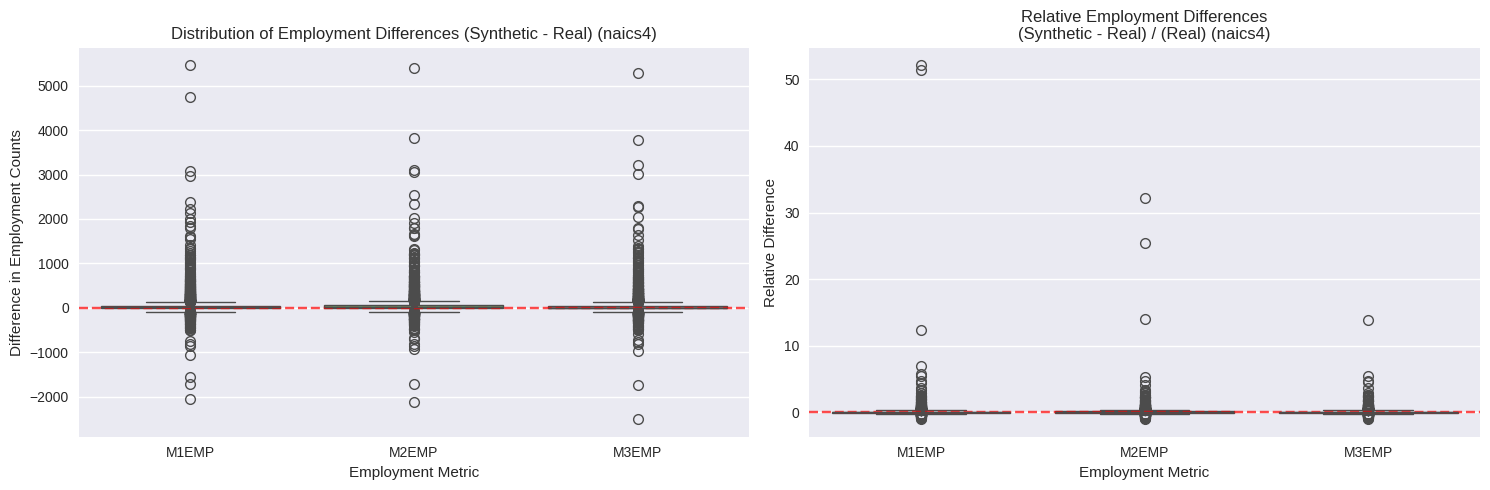

/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f

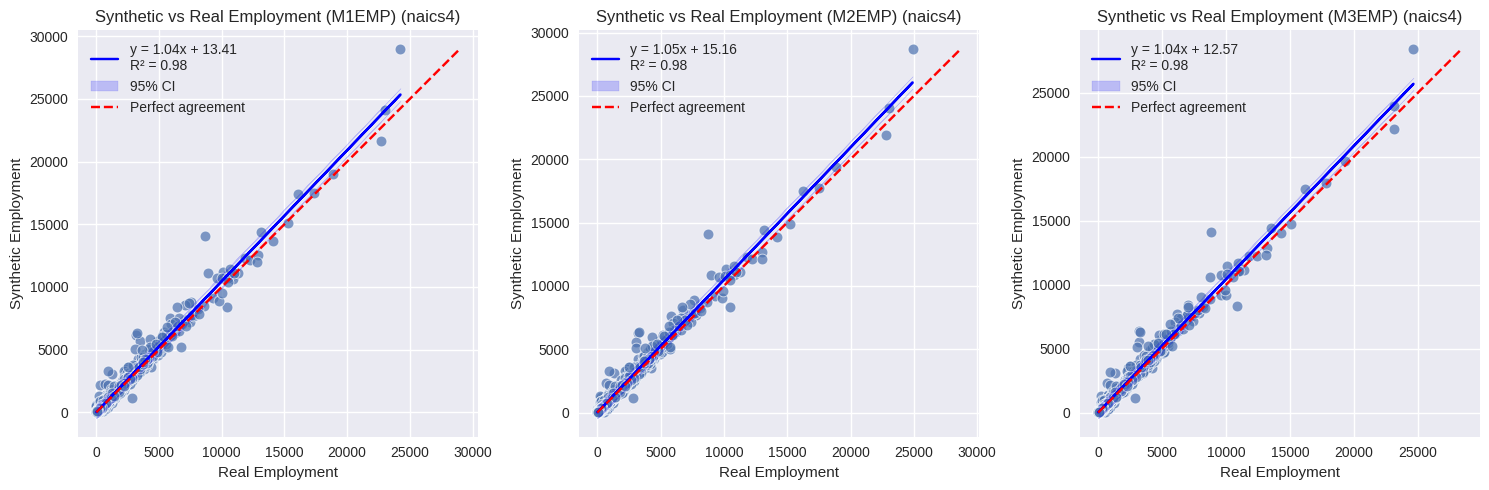

In [20]:
empresultout(result_df_4dig, 'naics4')

### Looking at the 5-digit level

#### Setting up dfs

In [21]:
real_nj_data_5dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 5) & 
    (real_nj_data['own_code'] == 5) & 
    (~real_nj_data['industry_code'].str.contains('-'))  # Excludes any codes with hyphens
]
synth_nj_df_5dig = synth_nj_df.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics5']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()
# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_5dig['naics5'] = synth_nj_df_5dig['naics5'].astype(str).str.strip().astype(int)
real_nj_data_5dig['industry_code'] = real_nj_data_5dig['industry_code'].astype(str).str.strip().astype(int)
# First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_5dig['naics5']).intersection(set(real_nj_data_5dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_5dig = synth_nj_df_5dig[synth_nj_df_5dig['naics5'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_5dig = real_nj_data_5dig[real_nj_data_5dig['industry_code'].isin(common_codes)]
real_nj_data_5dig['cnty'] = real_nj_data_5dig['cnty'].astype(int)
real_nj_data_5dig['state'] = real_nj_data_5dig['state'].astype(int)
real_nj_data_5dig['naics5'] = real_nj_data_5dig['industry_code']
# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_5dig,
    real_nj_data_5dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics5'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_5dig = merged_df[['year', 'qtr', 'state', 'cnty', 'naics5', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]
result_df_5dig = result_df_5dig[result_df_5dig['m1emp_real'] != 0]

/tmp/ipykernel_2842/1684374336.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_5dig['industry_code'] = real_nj_data_5dig['industry_code'].astype(str).str.strip().astype(int)


### 5-digit level results

Difference Statistics:
        m1emp_diff   m2emp_diff   m3emp_diff
count  4624.000000  4624.000000  4624.000000
mean     32.813798    34.428633    30.943555
std     256.709583   250.284880   247.564529
min   -2206.000000 -2399.000000 -2503.000000
25%     -25.000000   -24.000000   -25.000000
50%       4.000000     5.000000     4.000000
75%      50.000000    52.250000    50.000000
max    6855.000000  6172.000000  5883.000000

Correlation Matrix:
            m1emp_diff  m2emp_diff  m3emp_diff
m1emp_diff    1.000000    0.990653    0.974343
m2emp_diff    0.990653    1.000000    0.988957
m3emp_diff    0.974343    0.988957    1.000000

Median Differences by NAICS Sector:
        m1emp_diff  m2emp_diff  m3emp_diff
naics5                                    
11411         -8.0        -5.0       -10.0
11511          7.0         7.0         5.0
11521         -3.5        -5.0        -4.5
21232          7.0         9.5         5.0
22111       -135.0      -137.0      -133.0
...            ...       

<Figure size 1500x500 with 0 Axes>

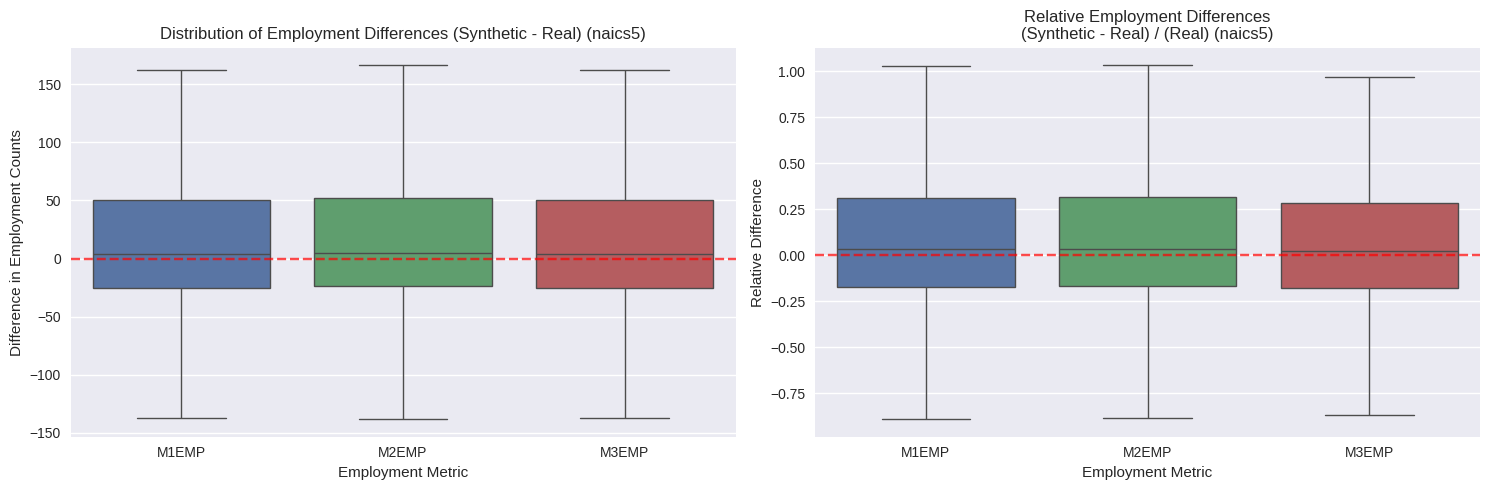

<Figure size 1500x500 with 0 Axes>

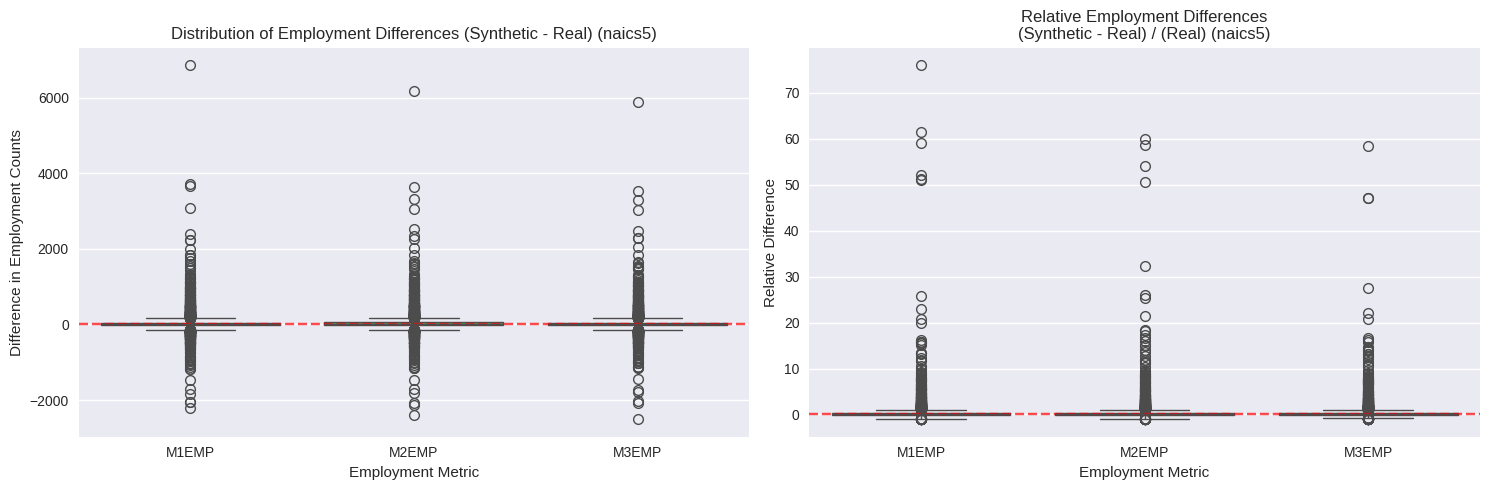

/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f

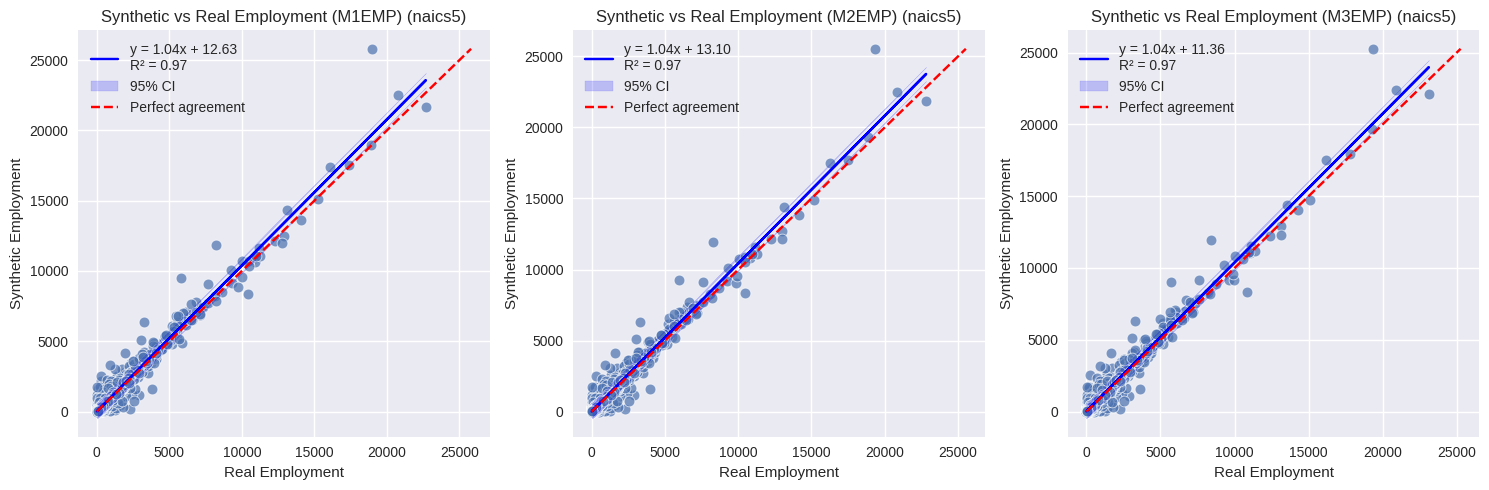

In [22]:
empresultout(result_df_5dig, 'naics5')

### Looking at the 6-digit level

#### Setting up dfs

In [23]:
real_nj_data_6dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 6) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_6dig = synth_nj_df.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics']
).agg({
    'm1emp': 'sum',
    'm2emp': 'sum', 
    'm3emp': 'sum'
}).reset_index()
# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_6dig['naics'] = synth_nj_df_6dig['naics'].astype(str).str.strip().astype(int)
real_nj_data_6dig['industry_code'] = real_nj_data_6dig['industry_code'].astype(str).str.strip().astype(int)
# First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_6dig['naics']).intersection(set(real_nj_data_6dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_6dig = synth_nj_df_6dig[synth_nj_df_6dig['naics'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_6dig = real_nj_data_6dig[real_nj_data_6dig['industry_code'].isin(common_codes)]
real_nj_data_6dig['cnty'] = real_nj_data_6dig['cnty'].astype(int)
real_nj_data_6dig['state'] = real_nj_data_6dig['state'].astype(int)
real_nj_data_6dig['naics'] = real_nj_data_6dig['industry_code']
# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_6dig,
    real_nj_data_6dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics'],
    suffixes=('_synth', '_real')
)

# Calculate differences
merged_df['m1emp_diff'] = merged_df['m1emp_synth'] - merged_df['m1emp_real']
merged_df['m2emp_diff'] = merged_df['m2emp_synth'] - merged_df['m2emp_real']
merged_df['m3emp_diff'] = merged_df['m3emp_synth'] - merged_df['m3emp_real']

# Select relevant columns for the result
result_df_6dig = merged_df[['year', 'qtr', 'state', 'cnty', 'naics', 
                      'm1emp_synth', 'm1emp_real', 'm1emp_diff',
                      'm2emp_synth', 'm2emp_real', 'm2emp_diff',
                      'm3emp_synth', 'm3emp_real', 'm3emp_diff']]
result_df_6dig = result_df_6dig[result_df_6dig['m1emp_real'] != 0]


/tmp/ipykernel_2842/1127110994.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_6dig['industry_code'] = real_nj_data_6dig['industry_code'].astype(str).str.strip().astype(int)


### 6-digit level results

Difference Statistics:
        m1emp_diff   m2emp_diff   m3emp_diff
count  4772.000000  4772.000000  4772.000000
mean     28.518022    29.565172    26.686295
std     306.272291   301.360541   299.624634
min   -5557.000000 -5631.000000 -5997.000000
25%     -29.000000   -28.000000   -30.000000
50%       3.000000     3.000000     2.000000
75%      50.000000    51.000000    50.000000
max    6855.000000  6172.000000  6013.000000

Correlation Matrix:
            m1emp_diff  m2emp_diff  m3emp_diff
m1emp_diff    1.000000    0.994068    0.983477
m2emp_diff    0.994068    1.000000    0.993139
m3emp_diff    0.983477    0.993139    1.000000

Median Differences by NAICS Sector:
        m1emp_diff  m2emp_diff  m3emp_diff
naics                                     
114111       -11.0         6.0         3.0
115115         7.0         7.0         5.0
115210        -3.5        -5.0        -4.5
221112       -70.0       -74.0       -74.0
221122        51.0        52.0        51.0
...            ...       

<Figure size 1500x500 with 0 Axes>

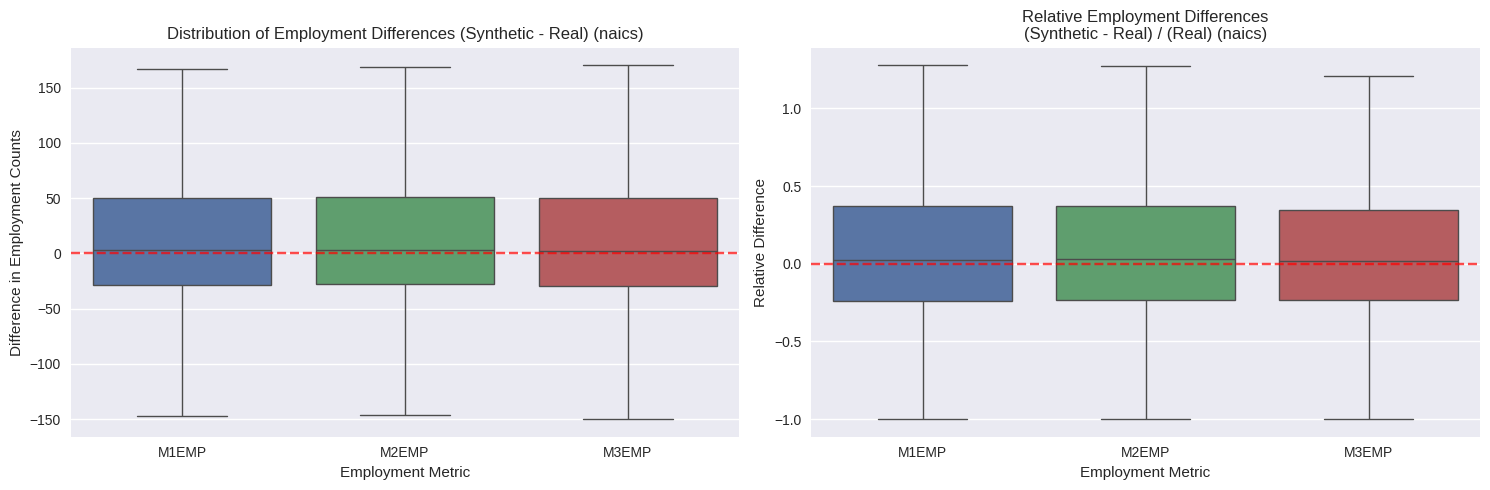

<Figure size 1500x500 with 0 Axes>

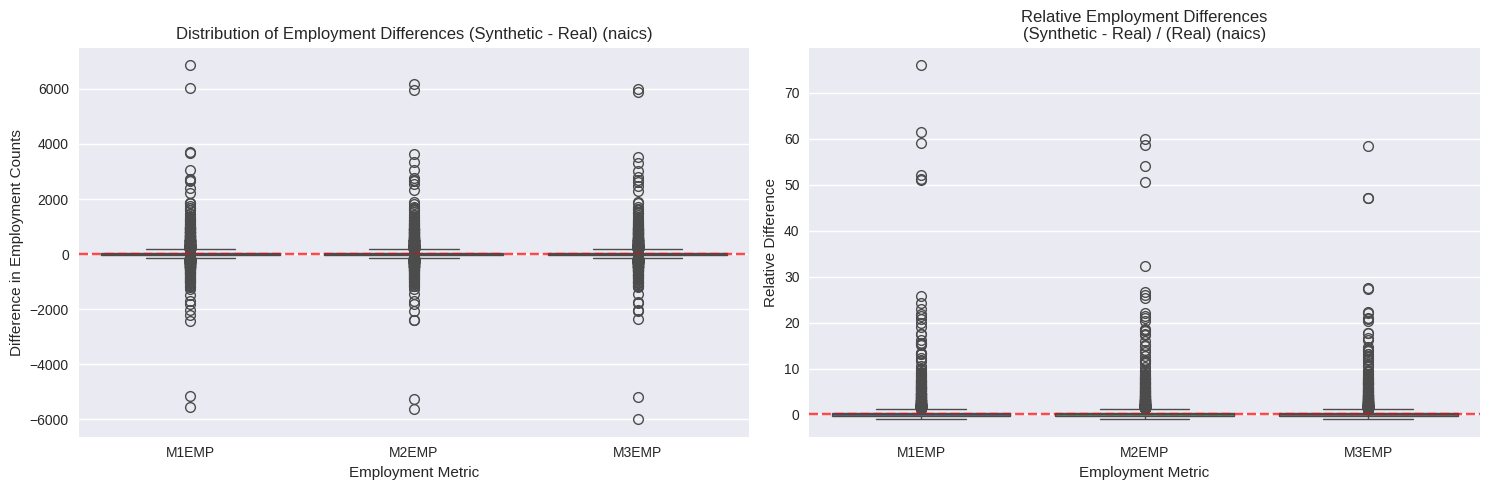

/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
/tmp/ipykernel_2842/1109055395.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f

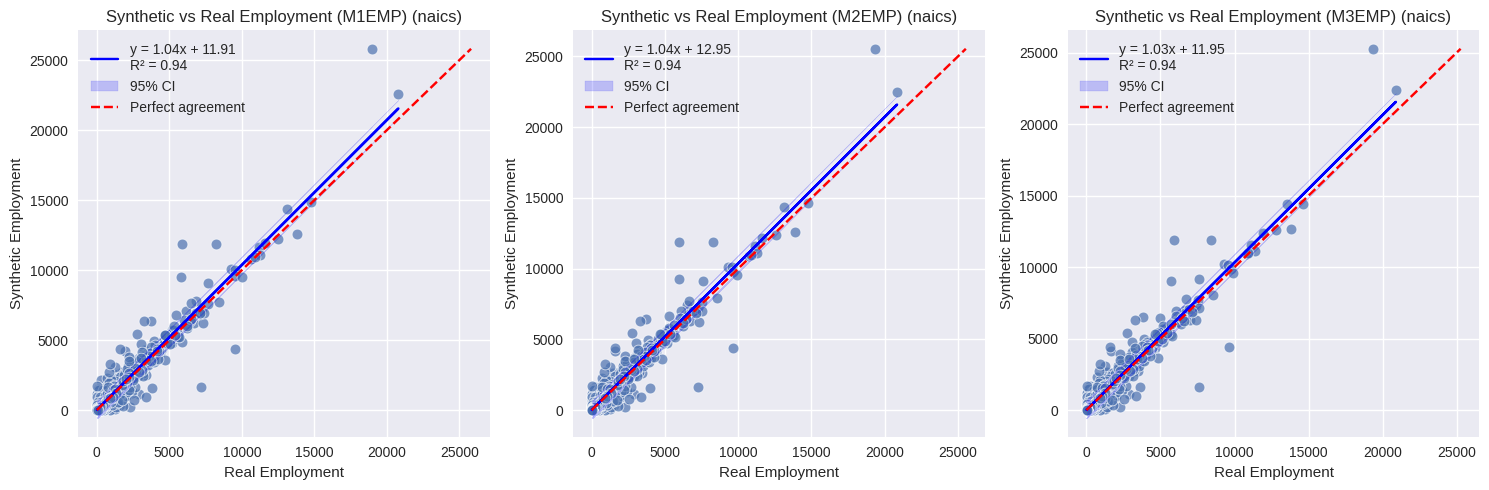

In [24]:
empresultout(result_df_6dig, 'naics')

## Step 3. Looking at wage counts at various NAICS Levels

We will do a similar analysis as before; however, we will now focus on wages rather than employment counts

Same as before, lets start at the 2-digit naics level.

I leave two result functions in allowing you to see the scatter plots on a log scale or untransformed.

### Looking at the 2-digit level for wages
#### Setting up dfs

In [25]:
real_nj_data_2dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 2) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_temp = synth_nj_df.copy()
synth_nj_df_temp['wage'] = synth_nj_df['wage'] * 1000
synth_nj_df_2dig = synth_nj_df_temp.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics_sector']
).agg({
    'wage': 'sum'
}).reset_index()
# # Convert to string first to handle any non-numeric values, then to int
synth_nj_df_2dig['naics_sector'] = synth_nj_df_2dig['naics_sector'].astype(str).str.strip().astype(int)
real_nj_data_2dig['industry_code'] = real_nj_data_2dig['industry_code'].astype(str).str.strip().astype(int)
# # First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_2dig['naics_sector']).intersection(set(real_nj_data_2dig['industry_code']))

# # Filter synthetic data to only keep rows with common codes
synth_nj_df_2dig = synth_nj_df_2dig[synth_nj_df_2dig['naics_sector'].isin(common_codes)]

# # Filter real data to only keep rows with common codes
real_nj_data_2dig = real_nj_data_2dig[real_nj_data_2dig['industry_code'].isin(common_codes)]
real_nj_data_2dig['cnty'] = real_nj_data_2dig['cnty'].astype(int)
real_nj_data_2dig['state'] = real_nj_data_2dig['state'].astype(int)
real_nj_data_2dig['naics_sector'] = real_nj_data_2dig['industry_code']
# # Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_2dig,
    real_nj_data_2dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics_sector']
)

# # # Calculate differences
merged_df['wage_diff'] = merged_df['wage'] - merged_df['total_qtrly_wages']
merged_df['rel_wage_diff'] = (merged_df['wage'] - merged_df['total_qtrly_wages']) / merged_df['total_qtrly_wages']
# # Select relevant columns for the result
result_df_2dig = merged_df[[
                            'year', 'qtr', 'state', 'cnty', 'naics_sector', 
                            'wage', 'total_qtrly_wages','wage_diff', 'rel_wage_diff'
                           ]]
result_df_2dig = result_df_2dig[result_df_2dig['total_qtrly_wages'] != 0]


/tmp/ipykernel_2842/920177403.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_2dig['industry_code'] = real_nj_data_2dig['industry_code'].astype(str).str.strip().astype(int)


In [47]:
def wageresultout(result_df, naicslevel):
    # Summary stats for differences
    diff_stats = result_df[['wage_diff', 'rel_wage_diff']].describe()
    print("Difference Statistics:")
    print(diff_stats)


    # By NAICS sector
    sector_stats = result_df.groupby(naicslevel)[['wage_diff', 'rel_wage_diff']].median()
    print("\nMedian Differences by NAICS Sector:")
    print(sector_stats)
#     ##### Plots #####
#     ## Box - no fliers
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(5, 5))  # Adjusted figure size for single plot

    
    sns.boxplot(data=result_df['wage_diff'],
           showfliers=False
           )
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    
    plt.tight_layout()
    plt.show()
#     ## Box with fliers
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(5, 5))  # Adjusted figure size for single plot

    
    sns.boxplot(data=result_df['rel_wage_diff'],
           showfliers=False
           )
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) / (Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    
    plt.tight_layout()
    plt.show()
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(5, 5))  # Adjusted figure size for single plot

    
    sns.boxplot(data=result_df['wage_diff'],
           showfliers=True
           )
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    
    plt.tight_layout()
    plt.show()
#     ## Box with fliers
    plt.style.use('seaborn-v0_8')  # Modern seaborn style
    plt.figure(figsize=(5, 5))  # Adjusted figure size for single plot

    
    sns.boxplot(data=result_df['rel_wage_diff'],
           showfliers=True
           )
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) / (Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)  # Add reference line at 0
    
    plt.tight_layout()
    plt.show()
    
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(5, 5))

    # Scatter plot
    sns.scatterplot(
        data=result_df,
        x='total_qtrly_wages',
        y='wage',
        s=60,
        alpha=0.7
    )

    # Fit regression with statsmodels (for CI)
    X = sm.add_constant(result_df['total_qtrly_wages'])  # Adds intercept
    model = sm.OLS(result_df['wage'], X).fit()

    # Generate predictions with CI
    predictions = model.get_prediction(X)
    pred_frame = predictions.summary_frame(alpha=0.05)  # 95% CI

    # Plot regression line
    plt.plot(
        result_df['total_qtrly_wages'],
        model.predict(X),
        color='blue',
        label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
    )

    # Plot CI
    plt.fill_between(
        result_df['total_qtrly_wages'],
        pred_frame['obs_ci_lower'],
        pred_frame['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='95% CI'
    )

    # Perfect agreement line
    max_val = max(result_df['total_qtrly_wages'].max(), result_df['wage'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect agreement')

    plt.title(f'Synthetic vs Real Wages ({naicslevel})')
    plt.xlabel('Real Wages')
    plt.ylabel('Synthetic Wages')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [77]:
def wageresultout(result_df, naicslevel):
    # Filter out zeros and negative values before log transform
    plot_df = result_df[(result_df['total_qtrly_wages'] > 0) & 
                       (result_df['wage'] > 0)].copy()
    
    # Summary stats for differences
    diff_stats = result_df[['wage_diff', 'rel_wage_diff']].describe()
    print("Difference Statistics:")
    print(diff_stats)

    # By NAICS sector
    sector_stats = result_df.groupby(naicslevel)[['wage_diff', 'rel_wage_diff']].median()
    print("\nMedian Differences by NAICS Sector:")
    print(sector_stats)

    ##### Plots #####
    ## Box - no fliers
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(5, 5))
    
    sns.boxplot(data=result_df['wage_diff'], showfliers=False)
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    ## Relative differences - no fliers
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=result_df['rel_wage_diff'], showfliers=False)
    plt.title(f'Relative Wage Differences (Synthetic - Real)/Real ({naicslevel})')
    plt.ylabel('Relative Difference')
    plt.xlabel('Relative Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    ## Box with fliers
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=result_df['wage_diff'], showfliers=True)
    plt.title(f'Distribution of Wage Differences (Synthetic - Real) ({naicslevel})')
    plt.ylabel('Difference in Wage Counts')
    plt.xlabel('Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    ## Relative differences with fliers
    plt.figure(figsize=(5, 5))
    sns.boxplot(data=result_df['rel_wage_diff'], showfliers=True)
    plt.title(f'Relative Wage Differences (Synthetic - Real)/Real ({naicslevel})')
    plt.ylabel('Relative Difference')
    plt.xlabel('Relative Wage Difference')
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    ##### Log-transformed Scatter Plot #####
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(5, 5))

    # Create log-transformed columns
    plot_df['log_real'] = np.log10(plot_df['total_qtrly_wages'])
    plot_df['log_synth'] = np.log10(plot_df['wage'])

    # Scatter plot with log scale
    sns.scatterplot(
        data=plot_df,
        x='log_real',
        y='log_synth',
        s=60,
        alpha=0.7
    )

    # Fit regression on log-transformed data
    X = sm.add_constant(plot_df['log_real'])
    model = sm.OLS(plot_df['log_synth'], X).fit()

    # Generate predictions with CI
    predictions = model.get_prediction(X)
    pred_frame = predictions.summary_frame(alpha=0.05)

    # Plot regression line
    plt.plot(
        plot_df['log_real'],
        model.predict(X),
        color='blue',
        label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'
    )

    # Plot CI
    plt.fill_between(
        plot_df['log_real'],
        pred_frame['obs_ci_lower'],
        pred_frame['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='95% CI'
    )

    # Perfect agreement line
    max_log = max(plot_df['log_real'].max(), plot_df['log_synth'].max())
    min_log = min(plot_df['log_real'].min(), plot_df['log_synth'].min())
    plt.plot([min_log, max_log], [min_log, max_log], 'r--', label='Perfect agreement')

    plt.title(f'Log10 Synthetic vs Real Wages ({naicslevel})')
    plt.xlabel('Log10(Real Wages)')
    plt.ylabel('Log10(Synthetic Wages)')
    plt.legend()

    plt.tight_layout()
    plt.show()

Difference Statistics:
          wage_diff  rel_wage_diff
count  3.080000e+02     308.000000
mean   7.650135e+07       4.496001
std    5.043050e+08      37.237330
min   -3.878087e+08      -0.994832
25%   -8.125792e+05      -0.042533
50%    4.463297e+06       0.163608
75%    3.191077e+07       0.666251
max    8.002062e+09     469.994905

Median Differences by NAICS Sector:
               wage_diff  rel_wage_diff
naics_sector                           
11            -1117239.0      -0.762632
21               14587.5       0.051459
22            43010681.0       2.082511
23             3000981.0       0.069810
42            95837295.5       1.016216
51            -2729935.0      -0.073603
52             8439122.0       0.081891
53             2427169.0       0.176392
54              351803.0       0.030849
55             7337134.0       0.112164
56             -264326.0      -0.004947
61            12204677.0       0.780503
62            99624319.0       0.406664
71             1266872.0 

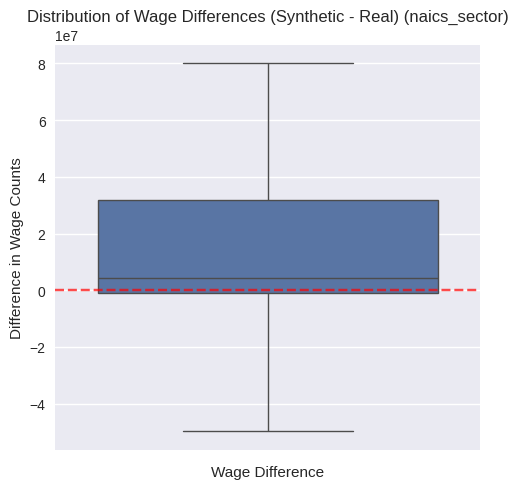

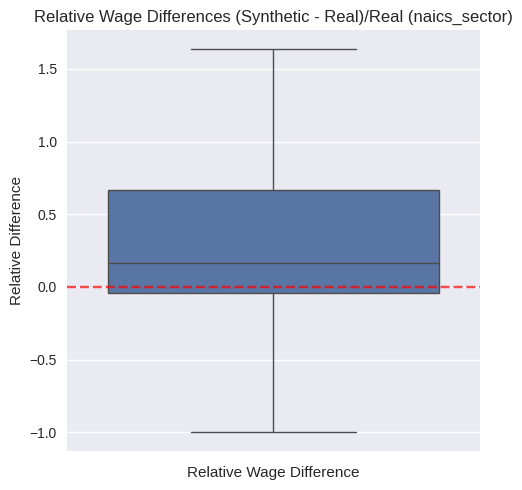

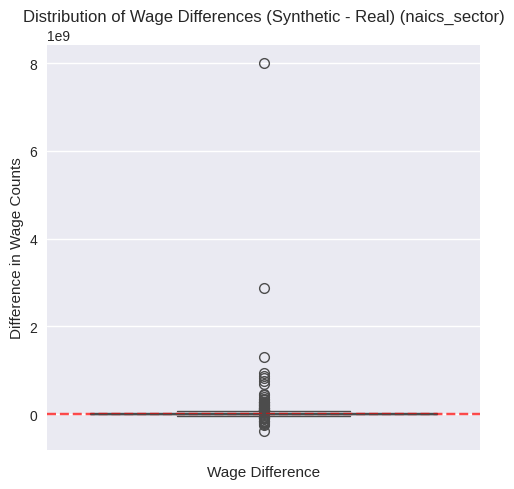

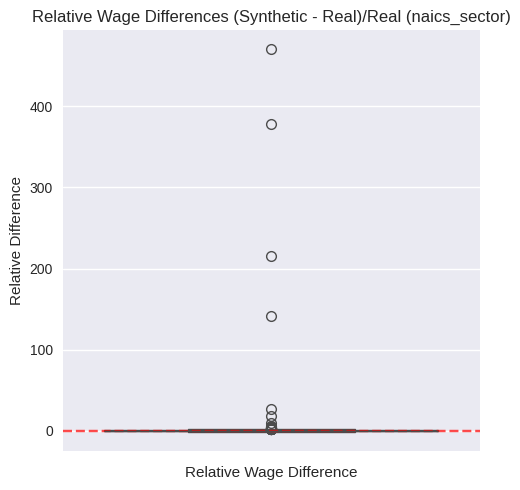

/tmp/ipykernel_2842/3459994209.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'


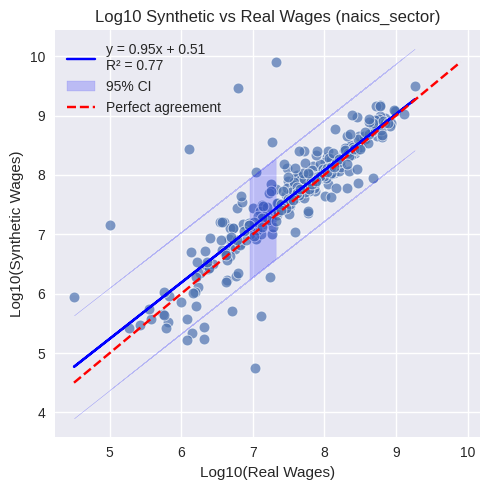

In [78]:
wageresultout(result_df_2dig, 'naics_sector')

In [79]:
real_nj_data_3dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 3) & 
    (real_nj_data['own_code'] == 5)
]
synth_nj_df_temp = synth_nj_df.copy()
synth_nj_df_temp['wage'] = synth_nj_df['wage'] * 1000
synth_nj_df_3dig = synth_nj_df_temp.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics3']
).agg({
    'wage': 'sum'
}).reset_index()
# # Convert to string first to handle any non-numeric values, then to int
synth_nj_df_3dig['naics3'] = synth_nj_df_3dig['naics3'].astype(str).str.strip().astype(int)
real_nj_data_3dig['industry_code'] = real_nj_data_3dig['industry_code'].astype(str).str.strip().astype(int)
# # First get the intersection of common NAICS codes
common_codes = set(synth_nj_df_3dig['naics3']).intersection(set(real_nj_data_3dig['industry_code']))

# # Filter synthetic data to only keep rows with common codes
synth_nj_df_3dig = synth_nj_df_3dig[synth_nj_df_3dig['naics3'].isin(common_codes)]

# # Filter real data to only keep rows with common codes
real_nj_data_3dig = real_nj_data_3dig[real_nj_data_3dig['industry_code'].isin(common_codes)]
real_nj_data_3dig['cnty'] = real_nj_data_3dig['cnty'].astype(int)
real_nj_data_3dig['state'] = real_nj_data_3dig['state'].astype(int)
real_nj_data_3dig['naics3'] = real_nj_data_3dig['industry_code']
# # Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_3dig,
    real_nj_data_3dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics3']
)

# # # Calculate differences
merged_df['wage_diff'] = merged_df['wage'] - merged_df['total_qtrly_wages']
merged_df['rel_wage_diff'] = (merged_df['wage'] - merged_df['total_qtrly_wages']) / merged_df['total_qtrly_wages']
# # Select relevant columns for the result
result_df_3dig = merged_df[[
                            'year', 'qtr', 'state', 'cnty', 'naics3', 
                            'wage', 'total_qtrly_wages','wage_diff', 'rel_wage_diff'
                           ]]
result_df_3dig = result_df_3dig[result_df_3dig['total_qtrly_wages'] != 0]


/tmp/ipykernel_2842/613502961.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_3dig['industry_code'] = real_nj_data_3dig['industry_code'].astype(str).str.strip().astype(int)


Difference Statistics:
          wage_diff  rel_wage_diff
count  1.086000e+03    1086.000000
mean   4.562397e+07      10.513295
std    3.778882e+08      93.274332
min   -3.878087e+08      -0.990490
25%   -1.067710e+06      -0.106062
50%    7.519410e+05       0.131011
75%    9.312716e+06       0.971821
max    8.002062e+09    1602.179743

Median Differences by NAICS Sector:
         wage_diff  rel_wage_diff
naics3                           
114       280202.0       0.592526
115       -56196.0      -0.107592
212       -42772.5      -0.074377
221     43010681.0       2.082511
236      -160521.0      -0.044275
...            ...            ...
721       -34972.0      -0.005334
722      -795397.0      -0.017715
811        99249.0       0.003272
812      -335726.0      -0.060504
813      6840073.0       0.788125

[69 rows x 2 columns]


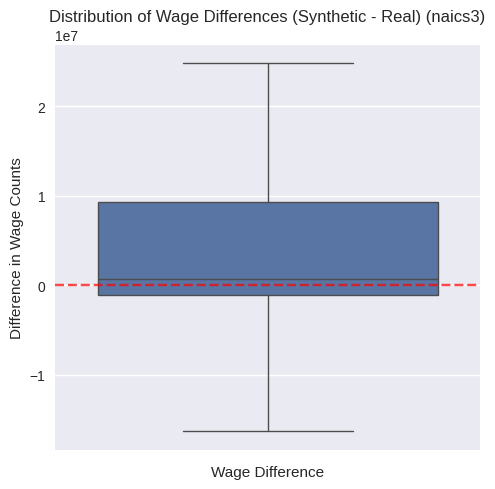

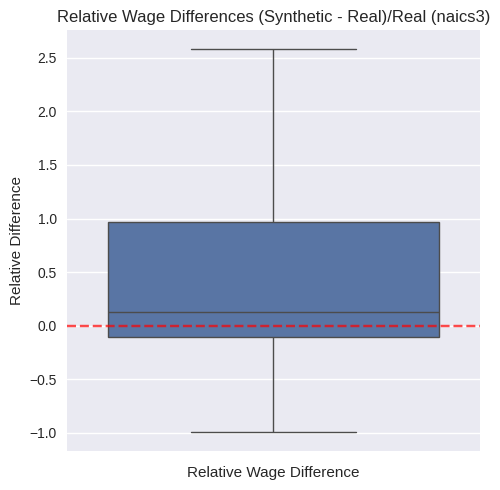

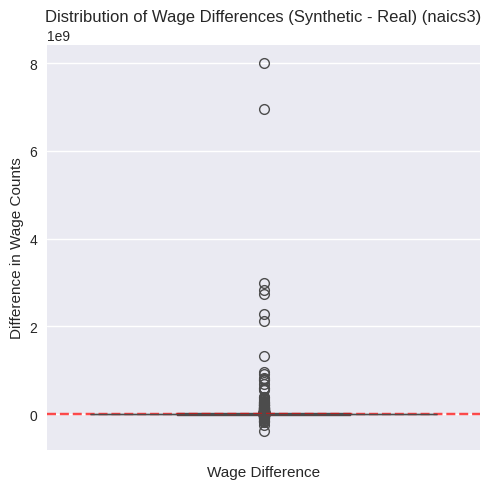

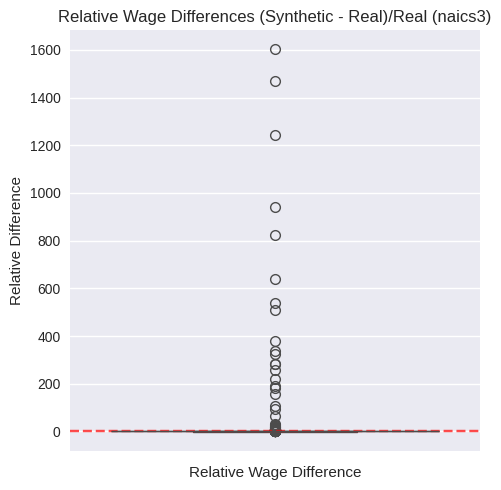

/tmp/ipykernel_2842/3459994209.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'


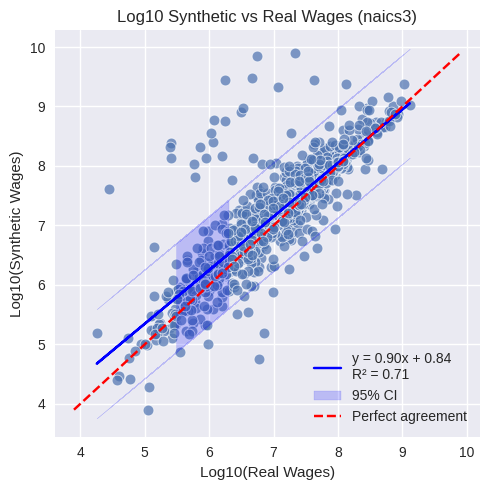

In [80]:
wageresultout(result_df_3dig, 'naics3')

In [81]:
# Filter for 4-digit NAICS and ownership code 5
real_nj_data_4dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 4) & 
    (real_nj_data['own_code'] == 5)
]

# Prepare synthetic data - convert wage to same units and group by 4-digit NAICS
synth_nj_df_temp = synth_nj_df.copy()
synth_nj_df_temp['wage'] = synth_nj_df['wage'] * 1000
synth_nj_df_4dig = synth_nj_df_temp.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics4']
).agg({
    'wage': 'sum'
}).reset_index()

# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_4dig['naics4'] = synth_nj_df_4dig['naics4'].astype(str).str.strip().astype(int)
real_nj_data_4dig['industry_code'] = real_nj_data_4dig['industry_code'].astype(str).str.strip().astype(int)

# Get the intersection of common NAICS codes
common_codes = set(synth_nj_df_4dig['naics4']).intersection(set(real_nj_data_4dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_4dig = synth_nj_df_4dig[synth_nj_df_4dig['naics4'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_4dig = real_nj_data_4dig[real_nj_data_4dig['industry_code'].isin(common_codes)]

# Standardize column names and types
real_nj_data_4dig['cnty'] = real_nj_data_4dig['cnty'].astype(int)
real_nj_data_4dig['state'] = real_nj_data_4dig['state'].astype(int)
real_nj_data_4dig['naics4'] = real_nj_data_4dig['industry_code']

# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_4dig,
    real_nj_data_4dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics4']
)

# Calculate differences
merged_df['wage_diff'] = merged_df['wage'] - merged_df['total_qtrly_wages']
merged_df['rel_wage_diff'] = (merged_df['wage'] - merged_df['total_qtrly_wages']) / merged_df['total_qtrly_wages']

# Select relevant columns for the result
result_df_4dig = merged_df[[
    'year', 'qtr', 'state', 'cnty', 'naics4', 
    'wage', 'total_qtrly_wages', 'wage_diff', 'rel_wage_diff'
]]

# Remove rows where real wages are zero to avoid division issues
result_df_4dig = result_df_4dig[result_df_4dig['total_qtrly_wages'] != 0]

/tmp/ipykernel_2842/4013910675.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_4dig['industry_code'] = real_nj_data_4dig['industry_code'].astype(str).str.strip().astype(int)


Difference Statistics:
          wage_diff  rel_wage_diff
count  2.786000e+03    2786.000000
mean   6.652201e+06       6.850864
std    1.098474e+08     131.850736
min   -5.212664e+08      -0.990168
25%   -1.040338e+06      -0.257228
50%   -1.396650e+04      -0.010471
75%    1.260549e+06       0.372584
max    2.980660e+09    6478.504822

Median Differences by NAICS Sector:
         wage_diff  rel_wage_diff
naics4                           
1141      151963.0       0.133884
1151       24418.0       0.616897
1152      187704.5       3.618429
2123      -42772.5      -0.074377
2211    14032551.0       0.761735
...            ...            ...
8131     9512125.0       8.112716
8132       43671.0       0.111361
8133     -594462.5      -0.350595
8134     -802385.5      -0.418010
8139       37269.0       0.046664

[223 rows x 2 columns]


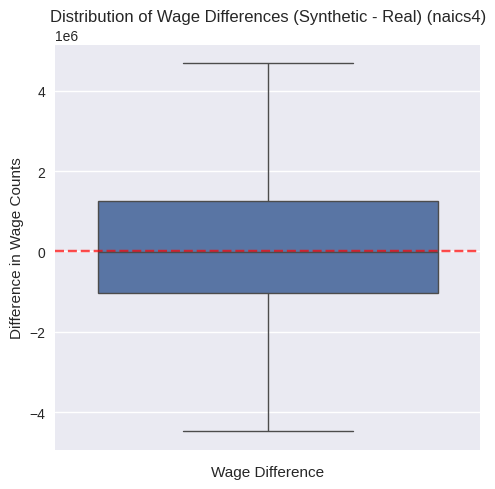

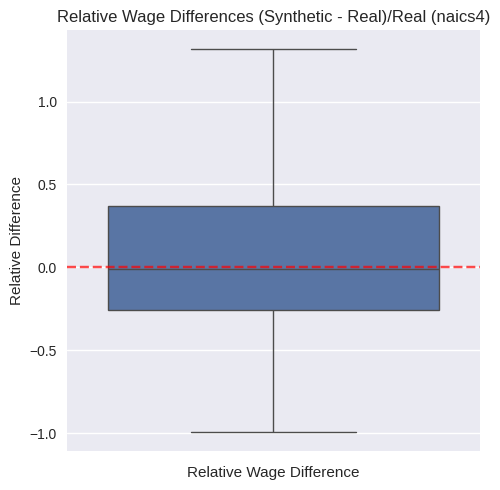

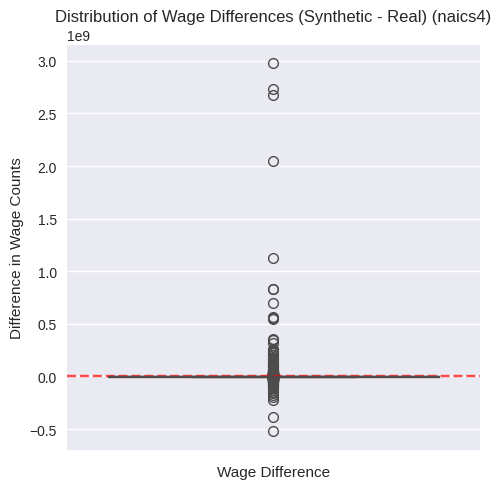

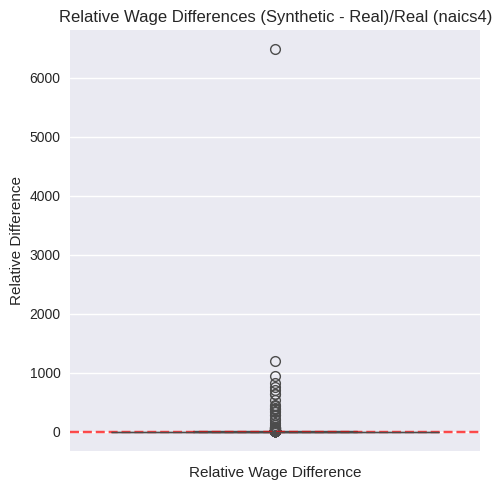

/tmp/ipykernel_2842/3459994209.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'


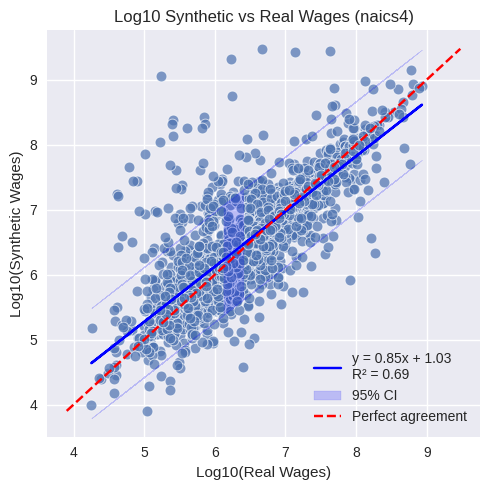

In [82]:
wageresultout(result_df_4dig, 'naics4')

In [83]:
# Filter for 5-digit NAICS and ownership code 5
real_nj_data_5dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 5) & 
    (real_nj_data['own_code'] == 5) & 
    (~real_nj_data['industry_code'].str.contains('-'))
]

# Prepare synthetic data - convert wage to same units and group by 5-digit NAICS
synth_nj_df_temp = synth_nj_df.copy()
synth_nj_df_temp['wage'] = synth_nj_df['wage'] * 1000
synth_nj_df_5dig = synth_nj_df_temp.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics5']
).agg({
    'wage': 'sum'
}).reset_index()

# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_5dig['naics5'] = synth_nj_df_5dig['naics5'].astype(str).str.strip().astype(int)
real_nj_data_5dig['industry_code'] = real_nj_data_5dig['industry_code'].astype(str).str.strip().astype(int)

# Get the intersection of common NAICS codes
common_codes = set(synth_nj_df_5dig['naics5']).intersection(set(real_nj_data_5dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_5dig = synth_nj_df_5dig[synth_nj_df_5dig['naics5'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_5dig = real_nj_data_5dig[real_nj_data_5dig['industry_code'].isin(common_codes)]

# Standardize column names and types
real_nj_data_5dig['cnty'] = real_nj_data_5dig['cnty'].astype(int)
real_nj_data_5dig['state'] = real_nj_data_5dig['state'].astype(int)
real_nj_data_5dig['naics5'] = real_nj_data_5dig['industry_code']

# Merge the dataframes on county
merged_df = pd.merge(
    synth_nj_df_5dig,
    real_nj_data_5dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics5']
)

# Calculate differences
merged_df['wage_diff'] = merged_df['wage'] - merged_df['total_qtrly_wages']
merged_df['rel_wage_diff'] = (merged_df['wage'] - merged_df['total_qtrly_wages']) / merged_df['total_qtrly_wages']

# Select relevant columns for the result
result_df_5dig = merged_df[[
    'year', 'qtr', 'state', 'cnty', 'naics5', 
    'wage', 'total_qtrly_wages', 'wage_diff', 'rel_wage_diff'
]]

# Remove rows where real wages are zero to avoid division issues
result_df_5dig = result_df_5dig[result_df_5dig['total_qtrly_wages'] != 0]

/tmp/ipykernel_2842/783126966.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_5dig['industry_code'] = real_nj_data_5dig['industry_code'].astype(str).str.strip().astype(int)


Difference Statistics:
          wage_diff  rel_wage_diff
count  4.624000e+03    4624.000000
mean   1.519388e+06       3.281722
std    4.410691e+07      99.628437
min   -5.097223e+08      -0.998158
25%   -6.999670e+05      -0.342593
50%   -2.755950e+04      -0.034353
75%    5.719885e+05       0.397085
max    2.045610e+09    6478.504822

Median Differences by NAICS Sector:
        wage_diff  rel_wage_diff
naics5                          
11411    151963.0       0.133884
11511     24418.0       0.616897
11521    187704.5       3.618429
21232   -131364.0      -0.127134
22111  -3757212.0      -0.465565
...           ...            ...
81391   -402675.0      -0.381606
81392   -139861.0      -0.287271
81393    -32742.5      -0.043289
81394     -8910.5       0.014091
81399    460599.0       0.390070

[463 rows x 2 columns]


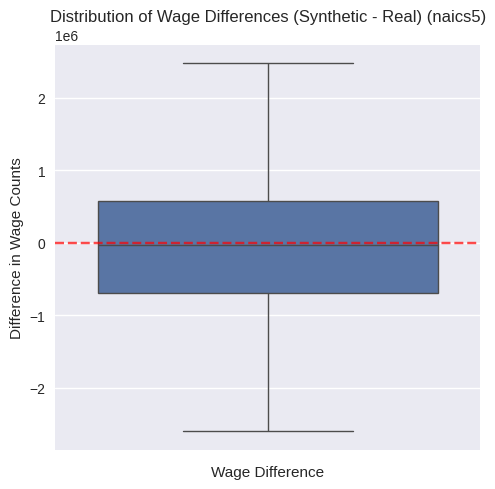

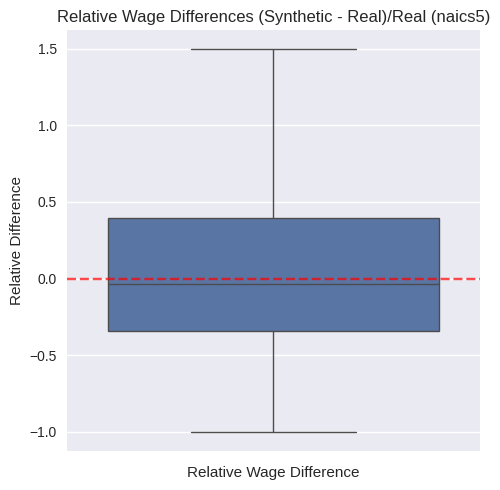

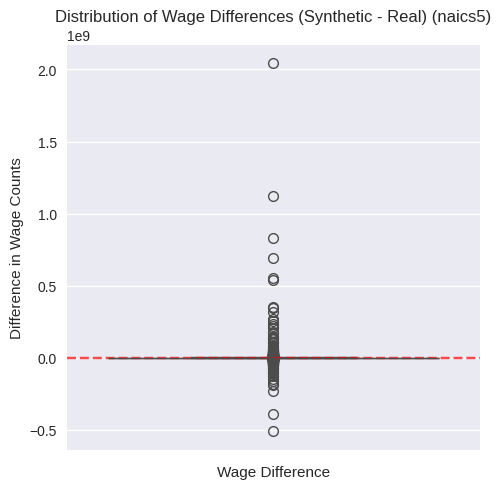

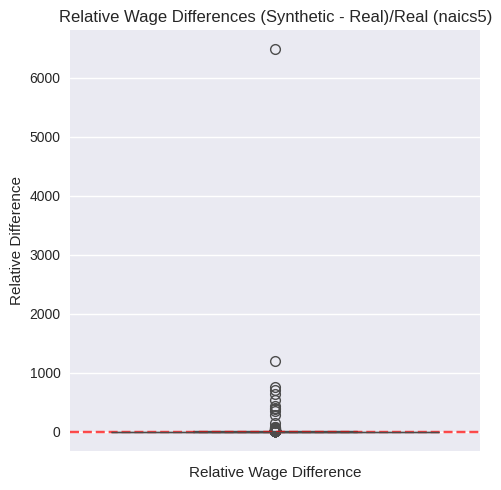

/tmp/ipykernel_2842/3459994209.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'


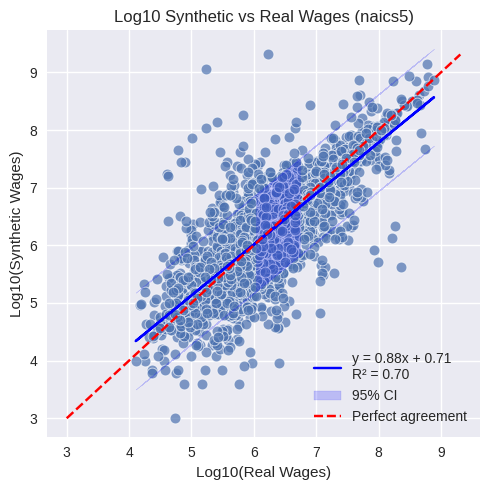

In [84]:
wageresultout(result_df_5dig, 'naics5')

In [85]:
# Filter for 6-digit NAICS and ownership code 5
real_nj_data_6dig = real_nj_data[
    (real_nj_data['industry_code'].str.len() == 6) & 
    (real_nj_data['own_code'] == 5)
]

# Prepare synthetic data - convert wage to same units and group by 6-digit NAICS
synth_nj_df_temp = synth_nj_df.copy()
synth_nj_df_temp['wage'] = synth_nj_df['wage'] * 1000
synth_nj_df_6dig = synth_nj_df_temp.groupby(
    ['year', 'qtr', 'state', 'cnty', 'own', 'naics']
).agg({
    'wage': 'sum'
}).reset_index()

# Convert to string first to handle any non-numeric values, then to int
synth_nj_df_6dig['naics'] = synth_nj_df_6dig['naics'].astype(str).str.strip().astype(int)
real_nj_data_6dig['industry_code'] = real_nj_data_6dig['industry_code'].astype(str).str.strip().astype(int)

# Get the intersection of common NAICS codes
common_codes = set(synth_nj_df_6dig['naics']).intersection(set(real_nj_data_6dig['industry_code']))

# Filter synthetic data to only keep rows with common codes
synth_nj_df_6dig = synth_nj_df_6dig[synth_nj_df_6dig['naics'].isin(common_codes)]

# Filter real data to only keep rows with common codes
real_nj_data_6dig = real_nj_data_6dig[real_nj_data_6dig['industry_code'].isin(common_codes)]

# Standardize column names and types
real_nj_data_6dig['cnty'] = real_nj_data_6dig['cnty'].astype(int)
real_nj_data_6dig['state'] = real_nj_data_6dig['state'].astype(int)
real_nj_data_6dig['naics'] = real_nj_data_6dig['industry_code']

# Merge the dataframes
merged_df = pd.merge(
    synth_nj_df_6dig,
    real_nj_data_6dig,
    on=['year', 'qtr', 'state', 'cnty', 'naics']
)

# Calculate differences
merged_df['wage_diff'] = merged_df['wage'] - merged_df['total_qtrly_wages']
merged_df['rel_wage_diff'] = (merged_df['wage'] - merged_df['total_qtrly_wages']) / merged_df['total_qtrly_wages']

# Select relevant columns for the result
result_df_6dig = merged_df[[
    'year', 'qtr', 'state', 'cnty', 'naics', 
    'wage', 'total_qtrly_wages', 'wage_diff', 'rel_wage_diff'
]]

# Remove rows where real wages are zero to avoid division issues
result_df_6dig = result_df_6dig[result_df_6dig['total_qtrly_wages'] != 0]

/tmp/ipykernel_2842/2025247857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_nj_data_6dig['industry_code'] = real_nj_data_6dig['industry_code'].astype(str).str.strip().astype(int)


Difference Statistics:
          wage_diff  rel_wage_diff
count  4.772000e+03    4772.000000
mean   9.824924e+05       2.667257
std    3.044333e+07      96.068274
min   -5.097223e+08      -0.998158
25%   -6.122455e+05      -0.385826
50%   -3.465650e+04      -0.047152
75%    4.494778e+05       0.364487
max    1.125154e+09    6478.504822

Median Differences by NAICS Sector:
        wage_diff  rel_wage_diff
naics                           
114111    -3177.0      -0.015637
115115    24418.0       0.616897
115210   187704.5       3.618429
221112 -1550125.0      -0.370212
221122   788277.0       0.272127
...           ...            ...
813910  -402675.0      -0.381606
813920  -139861.0      -0.287271
813930   -32742.5      -0.043289
813940    -8910.5       0.014091
813990   460599.0       0.390070

[549 rows x 2 columns]


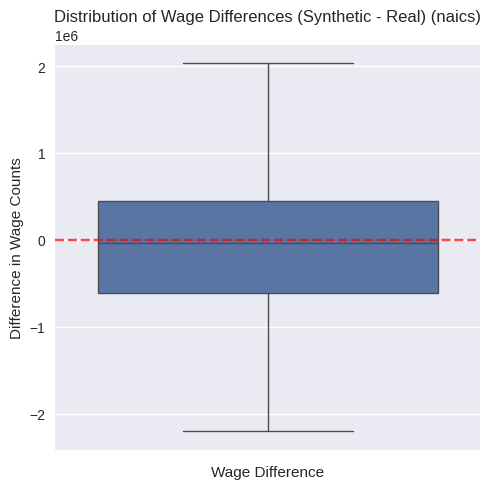

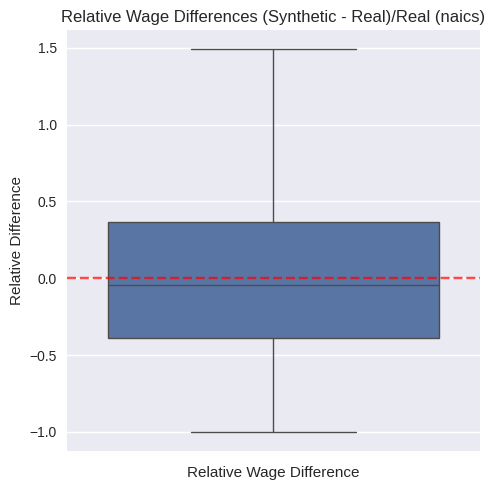

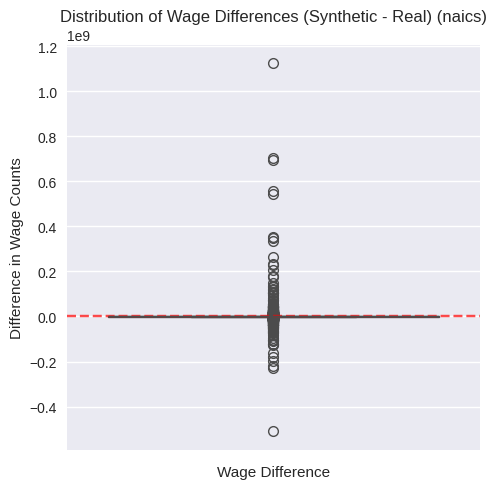

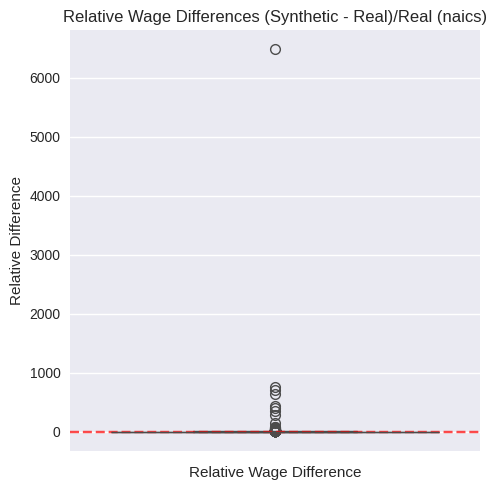

/tmp/ipykernel_2842/3459994209.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\nR² = {model.rsquared:.2f}'


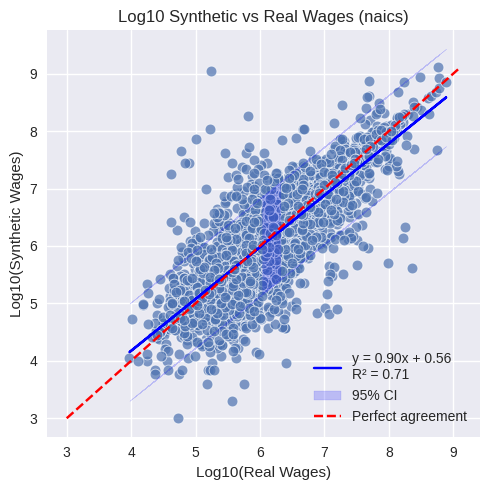

In [86]:
wageresultout(result_df_6dig, 'naics')